In [48]:
from scipy import ndimage as ndi
from sklearn.preprocessing import LabelEncoder
from keras.applications import Xception, ResNet50, InceptionResNetV2
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import random

In [49]:
#Input Parameters
#TILE_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/train_dataset_5x_10_12_19/tiles_5x')
TILE_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/gold_standards/1910_T/tiles_10x')
CANCER_PATH = TILE_PATH.joinpath('cancer')
NON_CANCER_PATH = TILE_PATH.joinpath('non-cancer')
BATCH_SIZE = 64
AUGMENT = False

#Output Parameters
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/features')

In [50]:
cancer_tile_paths = [path for path in CANCER_PATH.glob('*.jpeg')]
non_cancer_tile_paths = [path for path in NON_CANCER_PATH.glob('*.jpeg')]
all_tile_paths = cancer_tile_paths + non_cancer_tile_paths
#random.shuffle(all_tile_paths)

In [51]:
#xception_base = Xception(weights='imagenet', include_top=False)
#x = xception_base.output
#features = GlobalAveragePooling2D()(x)
#model = Model(inputs=xception_base.input, outputs=features)

# resnet_base = ResNet50(weights = 'imagenet', include_top = False)
# x = resnet_base.output
# features = GlobalAveragePooling2D()(x)
# model = Model(inputs=resnet_base.input, outputs=features)

inceptionresnetv2_base = InceptionResNetV2(weights = 'imagenet', include_top = False, pooling = 'avg')
model = Model(inputs = inceptionresnetv2_base.input, output = inceptionresnetv2_base.output)

/gpfs1/scratch/90days/s4436005/envs/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  if sys.path[0] == '':


In [52]:
total_batches = int(np.ceil(len(all_tile_paths)/BATCH_SIZE))
print(total_batches)
features_df = pd.DataFrame()

10


In [53]:
for (batch, i) in enumerate(range(0, len(all_tile_paths), BATCH_SIZE)):
    print('processing batch {0}/{1}'.format(batch + 1, total_batches))
    batch_paths = all_tile_paths[i:i + BATCH_SIZE]
    batch_labels = [path.parent.name for path in batch_paths]
    if AUGMENT:
        #Duplicate each label 4 times for data augmentation
        batch_labels = [x for x in batch_labels for _ in (0,1,2,3)]
        print(batch_labels)
    batch_imgs = []
    for path in batch_paths:
        #print(path)
        img = load_img(path, target_size = (299, 299))
        #img = load_img(path, target_size = (224, 224))
        img = img_to_array(img)
        if AUGMENT:
            for angle in [0, 90, 180, 270]:
                print(angle)
                img_rot = ndi.rotate(img, angle)
                img_rot = np.expand_dims(img_rot, axis = 0)
                img_rot = imagenet_utils.preprocess_input(img_rot)
                batch_imgs.append(img_rot.astype(np.uint8))
        else:
            img = np.expand_dims(img, axis = 0)
            img = imagenet_utils.preprocess_input(img)
            batch_imgs.append(img.astype(np.uint8))
    batch_imgs = np.vstack(batch_imgs)
    features = model.predict(batch_imgs, batch_size = BATCH_SIZE)
    features = features.reshape((features.shape[0]), 1536)
    batch_df = pd.DataFrame(features)
    batch_df['label'] = batch_labels
    features_df = pd.concat([features_df, batch_df], axis = 'index')

processing batch 1/10
processing batch 2/10
processing batch 3/10
processing batch 4/10
processing batch 5/10
processing batch 6/10
processing batch 7/10
processing batch 8/10
processing batch 9/10
processing batch 10/10


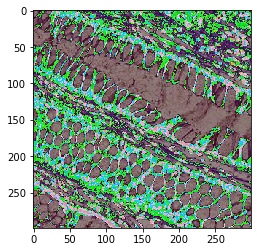

In [54]:
plt.imshow(batch_imgs[10])

In [55]:
features_df.reset_index(drop = True, inplace = True)

In [56]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
0,1.553547,1.704086,0.618356,249.892303,15.835061,11.433720,307.023743,0.000000,129.116592,84.381660,...,211.997635,66.261665,5.775931,217.791763,212.191132,118.440781,31.745798,95.884613,76.833138,cancer
1,0.058853,0.809275,0.369929,240.551178,13.285002,10.025867,297.458679,0.000000,126.925781,86.038834,...,205.266602,60.543324,6.970528,209.612305,207.693588,116.939110,32.599995,100.191902,72.531654,cancer
2,0.356443,1.017775,0.049190,255.685593,15.515215,11.008542,320.876129,0.000000,136.270081,95.127258,...,220.119705,68.115868,9.281830,223.398422,228.453583,124.111870,38.565063,114.766876,80.251381,cancer
3,0.013678,1.232089,0.437661,252.271805,12.826366,9.614866,310.249664,0.000000,132.208130,89.060516,...,212.581543,64.231064,6.763873,219.090485,217.818207,121.292847,33.938808,102.467918,78.747414,cancer
4,0.345144,1.026845,0.352816,256.610779,15.442823,11.819534,317.571716,0.000000,135.989609,91.592247,...,217.371170,65.930298,9.146255,223.809311,223.106628,124.166893,35.177494,107.348732,78.987167,cancer
5,0.000000,1.301869,0.763634,252.298004,15.243657,10.721474,315.893677,0.105416,136.838257,94.555054,...,219.552567,66.753075,8.182222,223.184128,226.953888,125.197685,39.186710,113.874428,76.198776,cancer
6,0.000000,1.156505,0.506167,234.764908,12.266288,9.917100,287.559113,0.000000,123.511940,82.770584,...,198.301895,60.148033,6.488240,204.024231,202.094131,112.138046,31.547123,94.530678,72.409042,cancer
7,0.000000,1.525142,0.515485,245.740295,13.896884,11.270659,304.053375,0.000000,128.535995,88.192360,...,209.405182,62.766659,7.924261,213.992996,215.334030,119.137390,35.498558,102.971428,75.876076,cancer
8,0.000000,0.542818,0.410906,249.409088,13.288253,9.117459,305.720490,0.000000,129.827667,86.479134,...,211.214645,64.865776,6.017609,218.240799,214.321152,120.964371,32.948292,95.748802,73.999123,cancer
9,0.111854,0.918876,0.272071,241.984085,13.188073,10.390599,305.091187,0.000000,127.525558,91.320946,...,210.342697,63.188736,9.041437,213.130219,214.836441,121.041924,34.922504,100.952652,73.397781,cancer


In [57]:
#features_df.to_csv(OUTPUT_PATH.joinpath('InceptionResNetv2_train_10_12_19_5x_features.csv'))
features_df.to_csv(OUTPUT_PATH.joinpath('InceptionResNetv2_1910_T_norm_features.csv'))